## Introduction:

The task is a variation of the [traveling salesman](https://en.wikipedia.org/wiki/Travelling_salesman_problem) problem. Santa must make several trips from the North Pole (lat,long = 90,0) to deliver presents around the world. His sled has a present weight limit of 1000 units, and itself weighs 10 units. The task is to devise a trip itinerary to minimize "reindeer weariness", defined as the cumulative sum of weight multiplied by the distance it is carried over. The general pattern we expect is for Santa to make trips to clusters of points whose gift-weights sum to ~1000, before returning to the North pole for another trip.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from itertools import chain
from santas_little_helper_functions import *
from sklearn.cluster import KMeans
%load_ext autoreload
%autoreload 2

In [2]:
df_gifts = pd.read_csv('gifts.csv')
df_samp_submission = pd.read_csv('sample_submission.csv')

## Exploratory Data Analysis

As we can see from the map below, the data is entirely random. It is therefore likely synthetic to protect proprietary naughty-or-nice data. Nonetheless, I will do my best to get the many children of Antarctica their presents on time.

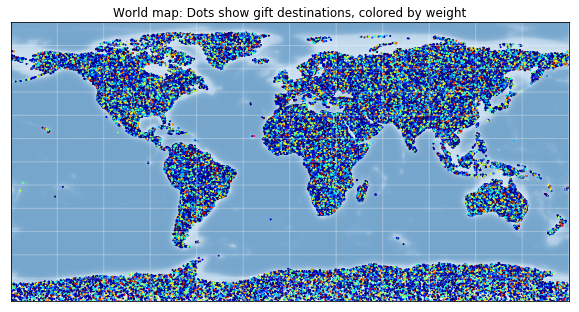

In [3]:
fig = plt.figure(figsize=(10, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
draw_map(m)
m.scatter(df_gifts['Longitude'],df_gifts['Latitude'], latlon=True, c=df_gifts['Weight'], cmap ='jet', s = 1)
plt.title('World map: Dots show gift destinations, colored by weight')
plt.show()

A sample solution is provided by Kaggle, composed of 5000 trips to random locations. Note that the units are specified for distance (KM), but no unites are specified for weight. This is the convention for Kaggle scoring in this competition, so I'll stick with it.

The maximum gift weight is 50, and the average is 14.

About 1/3rd of all presents weigh 1. 2.2% weigh 50.

At a carried weight of 1000, an absolute **minimum of 1410 trips** are needed to complete the deliveries. 

In [4]:
df_gifts['Weight'].describe()

count    100000.000000
mean         14.098391
std          14.080697
min           1.000000
25%           1.000000
50%          10.013013
75%          23.465783
max          50.000000
Name: Weight, dtype: float64

In [5]:
df_gifts['Weight'].value_counts().iloc[:4]

1.000000     32617
50.000000     2282
20.172691        1
11.852150        1
Name: Weight, dtype: int64

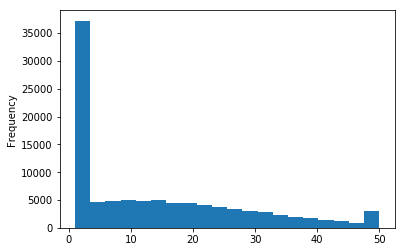

In [6]:
df_gifts['Weight'].plot.hist(bins=20)
plt.show()

In [7]:
print('minimum # of trips needed: {}'.format(round(df_gifts['Weight'].sum()/1000,0)))

minimum # of trips needed: 1410.0


We can also test our weariness (scoring) function, and verify that it matches the leaderboard "baseline". Additionally, we can see what kind of improvement to expect by looking at the best score. The winner was able to reduce weariness to 8.6% of baseline weariness.

In [8]:
df_gift_trips_sample = df_samp_submission.merge(df_gifts, on='GiftId')
%time baseline_weariness = compute_weariness(df_gift_trips_sample)
winning_score = 12384507107
print('baseline weariness: {}'.format(round(baseline_weariness)))
print('winning score: {}'.format(round(winning_score)))
print('reduction percentage: {}%'.format(round(winning_score/baseline_weariness,3)*100))

Wall time: 7.5 s
baseline weariness: 144525525772.0
winning score: 12384507107
reduction percentage: 8.6%


The main challenge of this project is computation. One could iterate over all possible trip configurations and choose the best score. Currently, with 5000 trips, my function takes about 8 seconds to compute a score. One key insight that is going to make this much, much faster, is that trips contribute to the score independently. So if I shuffle destinations between X trips, I only need to recompute the weariness for those trips to see if the overall score would improve.

Another key insight is the computation of distance. We have degrees latitude and longitude for each point, which can be mapped to a traveled distance using the haversine function. This is absolutely necessary for final computation of the error metric, and for large travel arcs, but for small deltas in lat/long angles, distance is very well approximated by a straight line. In fact, a change in angle is exactly proportinate to a change in arc length as the angle approaches zero:

<img src="arc_length_eqns.png" alt="Drawing" style="width: 300px;"/>

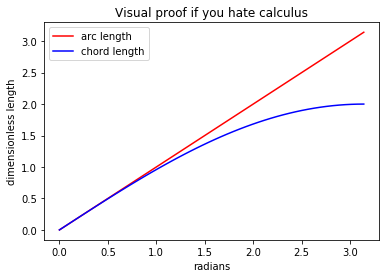

In [9]:
t = np.linspace(0,np.pi)
r = 1
s = r*t
d = 2*r*np.sin(t/2)
plt.plot(t, s, 'r'); plt.plot(t, d, 'b')
plt.xlabel('radians'); plt.ylabel('dimensionless length'); plt.legend(['arc length', 'chord length'])
plt.title('Visual proof if you hate calculus')
plt.show()

Thus, for the purposes of clustering, we can work with degrees latitude/longitude directly, and not have to repeatedly appeal to the haversine calculation to do distance comparisons between points.

## Solution strategy

The first and easiest idea I had was to do clustering within regions until the maximum trip weight was less than 1000 (by increasing k, the number of clusters). I thought this might work because the data is distributed randomly, so on average, each patch of land has the same gift weight. Unfortunately, this resulted in a lot of suboptimal trip weights. For example, by the time k-means clustering segments a region to where the the maximum trip weight is <1000, many other trips within that region have weights ~300.

Clustering the data into many "regions" and then planning trips within those regions is a better starting solution. I did this, and got reduction to 9.9% of baseline weariness, which is quite good. It turns out that the best solution is reached by initializing with 200 clusters, and planning trips up to a weight of only 250 (rather than 1000).

In [10]:
%time kmeans = KMeans(n_clusters=200, random_state=0, n_jobs = -1).fit(df_gifts[['Latitude', 'Longitude']])

Wall time: 1min 21s


In [11]:
df_gifts_trips_kmeans = df_gifts
df_gifts_trips_kmeans['RegionId'] = kmeans.predict(df_gifts[['Latitude', 'Longitude']])

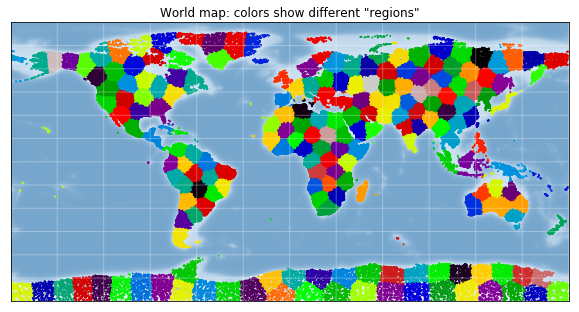

In [12]:
fig = plt.figure(figsize=(10, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
draw_map(m)
m.scatter(df_gifts_trips_kmeans['Longitude'],df_gifts_trips_kmeans['Latitude'], latlon=True, c=df_gifts_trips_kmeans['RegionId'], cmap ='nipy_spectral', s = 1)
plt.title('World map: colors show different "regions"')
plt.show()

The strategy for growing trips within regions is to pick the most remote point (from the region centroid), and add gift-destinations until a target weight is reached. This avoids isolated corners within regions.

Technically, clustering is not required. Trips can simply be planned in this fashion with appealing to the concept of "regions". But the solutions are very similar, as is total computation time. Overall, I chose to cluster first, because trip geometry can get a little strange in places if no regions are defined.

In [13]:
df_gifts_trips_by_region = pd.DataFrame()
trip_number = 1
for region_id in df_gifts_trips_kmeans['RegionId'].unique():
    df_region = df_gifts_trips_kmeans[df_gifts_trips_kmeans['RegionId']==region_id].reset_index()
    df_region_trips, trip_number = get_trips(df_region, trip_number, 250)
    df_gifts_trips_by_region = pd.concat([df_gifts_trips_by_region, df_region_trips], axis = 0)

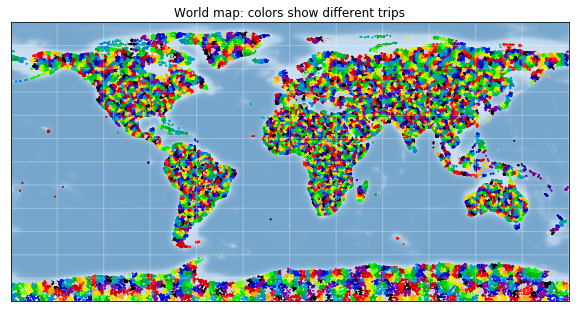

In [14]:
n_colors = 20
colors = df_gifts_trips_by_region['TripId'] % n_colors

fig = plt.figure(figsize=(10, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180)
draw_map(m)
m.scatter(df_gifts_trips_by_region['Longitude'],df_gifts_trips_by_region['Latitude'], latlon=True, c=colors, cmap ='nipy_spectral', s = 1)
plt.title('World map: colors show different trips')
plt.show()

Now the world has been divided into valid trips. The vast majority of trips take place at very close to 250 lbs of weight.

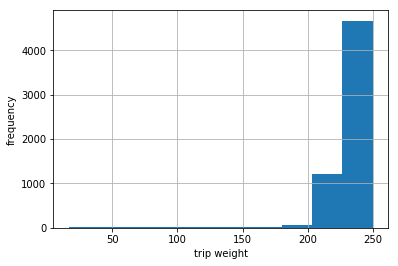

In [15]:
df_gifts_trips_by_region.groupby('TripId')['Weight'].sum().hist()
plt.ylabel('frequency')
plt.xlabel('trip weight')
plt.show()

In [16]:
score = compute_weariness(df_gifts_trips_by_region)
print('trip weight = 250')
print('pct of baseline weariness: {}%'.format(100*round(score/baseline_weariness,4)))

trip weight = 250
pct of baseline weariness: 9.9%


This is reasonably close to the leaderboard score of 8.6%, so I will use this solution as a seed for the next step.

I have a very, very strong intuition that sled weights of 1000 lbs ought to be optimal. Certainly, 250 is too low. Note that the sled weight is only 10. So 4 trips with 260 = 1040, vs 1 trip with 1010. So there is only a 30 lb penalty for having a very light sled load.

A genetic approach was originally proposed for this problem. I still believe it would work, but the computation load would be extreme. Instead, a very slimmed down genetic approach is implemented. The algorithm below starts a random trip, and computes the score-gain from combining with each of its 10 nearest trips based on centroid (on the condition that total weight <1000). The algorithm continues for a fixed number of iterations.

In [17]:
initial_score = score

In [18]:
df_test = df_gifts_trips_by_region.copy()

In [19]:
n_iter = 1000
for iteration in range(n_iter):
    master_trip = np.random.choice(df_test['TripId'].unique())
    trip_centroids = df_test.groupby('TripId')[['Latitude','Longitude']].mean()
    d_centroid = trip_centroids - trip_centroids[trip_centroids.index == master_trip].values[0]
    d_centroid = np.sqrt(d_centroid['Longitude']**2 + d_centroid['Latitude']**2)
    merge_test_locs = np.argsort(d_centroid.values)[1:11]
    slave_trip_ids = trip_centroids.index[merge_test_locs]
    score_gain = []
    for slave_trip_id in slave_trip_ids:
        df_mini = df_test[df_test['TripId'].isin([master_trip, slave_trip_id])].copy()
        unmerged_score = compute_weariness(df_mini)
        df_mini['TripId'] = master_trip
        if df_mini['Weight'].sum() < 1000:
            score_gain.append(unmerged_score-compute_weariness(df_mini))
        else:
            score_gain.append(-1)

    if np.max(score_gain) > 0:
        slave_trip_id = slave_trip_ids[np.argmax(score_gain)]
        df_test.loc[df_test['TripId'] == slave_trip_id, 'TripId'] = master_trip
        df_test.reset_index(inplace=True, drop = True)

In [20]:
df_gifts_trips_by_region['TripId'].unique().shape

(6071,)

In [21]:
df_test['TripId'].unique().shape

(5960,)

In [22]:
test_score = compute_weariness(df_test)
print('improved', (initial_score-test_score)/baseline_weariness)

improved 7.859244682179782e-05


The result is not good. After 1000 iterations, approximately 100 trips have been merged, and score improvement is minimal. It seems as though the light sled weight of 10 penalizes the shape of trip groups much, much more heavily than the number of trips made.

Currently, the order of gift-dropoffs within a trip is basically random. I doubt it will make much difference, because only a small proportion of the trip distance is completed within the trip-area. But nonetheless, I tried sorting by lat/long, and also by gift-weight (the logic being that all-else equal, heavier presents should be dropped off first).

In [23]:
df_lat_sort = df_gifts_trips_by_region.sort_values(['TripId', 'Latitude'])
score = compute_weariness(df_lat_sort)
print('trips sorted by latitude')
print('pct of baseline weariness: {}%'.format(100*round(score/baseline_weariness,4)))

trips sorted by latitude
pct of baseline weariness: 9.58%


In [24]:
df_weight_sort = df_gifts_trips_by_region.sort_values(['TripId', 'Weight'], ascending=False)
score = compute_weariness(df_weight_sort)
print('trips sorted by weight')
print('pct of baseline weariness: {}%'.format(100*round(score/baseline_weariness,4)))

trips sorted by weight
pct of baseline weariness: 9.47%


In [25]:
df_weight_lat_sort = df_gifts_trips_by_region.sort_values(['TripId', 'Weight', 'Latitude'], ascending=False)
score = compute_weariness(df_weight_lat_sort)
print('trips sorted by weight, then latitude')
print('pct of baseline weariness: {}%'.format(100*round(score/baseline_weariness,4)))

trips sorted by weight, then latitude
pct of baseline weariness: 9.46%


This worked much better than I expected. Sorting by weight is effective, but still receives some benefit from sorting by latitude. About 2/3rds of all gift-weights are arbitrary floats though, so sorting 10.38 and 10.37 could have the sled traveling to opposite ends of the trip-area. Sorting by an engineered column that rounds weights to the nearest 10 might help.

In [26]:
df_rounded_weight = df_gifts_trips_by_region.copy()
df_rounded_weight['Rounded_Weight'] = round(df_gifts_trips_by_region['Weight']/10)*10
df_rounded_weight = df_rounded_weight.sort_values(['TripId', 'Rounded_Weight', 'Latitude'], ascending=False)
score = compute_weariness(df_rounded_weight)
print('trips sorted by rounded weight, then latitude')
print('pct of baseline weariness: {}%'.format(100*round(score/baseline_weariness,4)))

trips sorted by rounded weight, then latitude
pct of baseline weariness: 9.43%


The last thing I'll try is manipulating the overall trip-area geometry. By sacling latitude by a factor of 10, destinations become stretched in the E-W direction. The motivation for this is to make sorting by position more profitable.

In [27]:
df_gifts_trips_stretch = df_gifts.copy()
df_gifts_trips_stretch['Latitude'] = df_gifts_trips_stretch['Latitude']*10
kmeans = KMeans(n_clusters=200, random_state=0, n_jobs = -1).fit(df_gifts_trips_stretch[['Latitude', 'Longitude']])
df_gifts_trips_stretch['RegionId'] = kmeans.predict(df_gifts_trips_stretch[['Latitude', 'Longitude']])

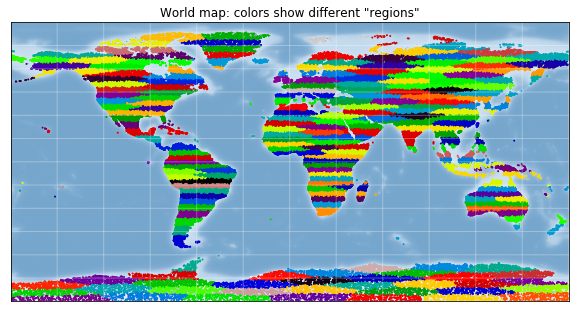

In [28]:
fig = plt.figure(figsize=(10, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
draw_map(m)
m.scatter(df_gifts_trips_stretch['Longitude'],df_gifts_trips_stretch['Latitude']/10, latlon=True, c=df_gifts_trips_stretch['RegionId'], cmap ='nipy_spectral', s = 1)
plt.title('World map: colors show different "regions"')
plt.show()

In [29]:
df_gifts_trips_by_region_stretch = pd.DataFrame()
trip_number = 1
for region_id in df_gifts_trips_stretch['RegionId'].unique():
    df_region = df_gifts_trips_stretch[df_gifts_trips_stretch['RegionId']==region_id].reset_index()
    df_region_trips, trip_number = get_trips(df_region, trip_number, 250)
    df_gifts_trips_by_region_stretch = pd.concat([df_gifts_trips_by_region_stretch, df_region_trips], axis = 0)

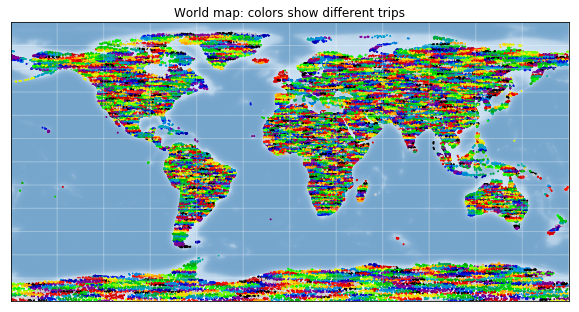

In [30]:
n_colors = 20
colors = df_gifts_trips_by_region_stretch['TripId'] % n_colors

fig = plt.figure(figsize=(10, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180)
draw_map(m)
m.scatter(df_gifts_trips_by_region_stretch['Longitude'],df_gifts_trips_by_region_stretch['Latitude']/10, latlon=True, c=colors, cmap ='nipy_spectral', s = 1)
plt.title('World map: colors show different trips')
plt.show()

In [31]:
df_gifts_trips_by_region_stretch['Latitude'] = df_gifts_trips_by_region_stretch['Latitude']/10

In [32]:
df_stretch_sorted = df_gifts_trips_by_region_stretch.copy()
df_stretch_sorted = df_stretch_sorted.sort_values(['TripId', 'Longitude'], ascending=False)
score = compute_weariness(df_stretch_sorted)
print('trips sorted by then latitude')
print('pct of baseline weariness: {}%'.format(100*round(score/baseline_weariness,4)))

trips sorted by then latitude
pct of baseline weariness: 9.4%


Sorting by weights, rounded weights, and rounded lat/long did not improve the score. I also went back and tried this with larger trip-weight clusters (1000, 500, instead of 250), and found that the score was not as good. This is likely because larger trip-areas are more difficult to sort intelligently.

In [33]:
df_gifts_trips_by_region_stretch[['GiftId','TripId']].to_csv('santa_route.csv', index = False)

If you read this far, thanks again! It was pretty fun, although I think I could do a lot better with more time to explore the data. The main trap was trying to get genetic algorithms to work without focusing on the fundamentals of trip planning. If I continued, I'd try to come up with better ways to solve the sub-problem of how to plan trips within an area.

 9.4% is the best score I achieved here, which compares reasonably to the #1 leaderboard score of 8.6% reduction over baseline.

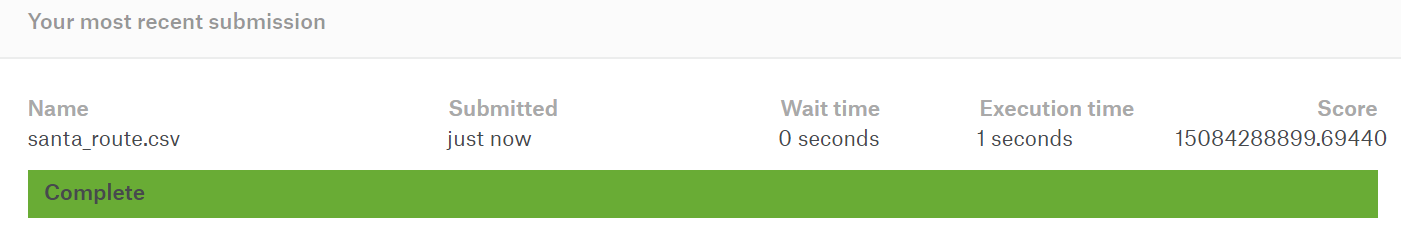